# Summary

This dataset provides hourly values for the number of active users for an e -scooter rental service in a city. The features include the date and various weather parameters. 
<br> The task is to predict the total number of active users (guest - users and registered - users)  in order to help in demand forecasting.

<b> The findings from EDA can be surmised largely in 2 parts.</b>
    <br>
    <br><b>&nbsp;&nbsp; 1. Issues with the dataset to be rectified during preprocessing. </b>
    <br>&nbsp;&nbsp;&nbsp;&nbsp; a) Negative users (target) values to be replaced with 0.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; b) Duplicated datapoints to be removed.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; c) Missing datapoints to be removed (days with < 22 datapoints) or forward filled (days with >= 22 datapoints)
    <br>&nbsp;&nbsp;&nbsp;&nbsp; d) Weather category having mispellings, to be rectified.
    <br>
    <br><b>&nbsp;&nbsp; 2. Useful features to be engineered as inputs for the model. </b>
    <br>&nbsp;&nbsp;&nbsp;&nbsp; a) Registered/Guest user demand have different relationships with explanatory variables. To be forecasted separately before aggregation.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; b) User demand have a lognormal distribution and underlying trend over the years. To ensure stationarity for better prediction, user demand will be logged and differenced.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; c) The month, day, time, and time/day interaction have impact on user demand. Features to be engineered as model inputs.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; d) Humidity and temperature have different sensitivity to user demand at different points of the day. To engineer these interaction terms as well.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; e) User demand has high autocorrelation, to use historic lags of user demand as features.
    <br>&nbsp;&nbsp;&nbsp;&nbsp; d) User demand mean and standard deviation are negatively correlated. Higher demand in the day (morning, evenings) have little fluctuations. While most fluctuations in user demand occurs post midnight, which, on average has lower user demand.
   <br>
   <br> These findings will be incorporated in the data pre-processing step.
   <br> The rationale/decision of dealing with data issues or to engineer specific features, along with other findings are further elaborated in the notebook.

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker

In [30]:
df = pd.read_csv('https://aisgaiap.blob.core.windows.net/aiap6-assessment-data/scooter_rental_data.csv')
df.to_csv('scooter_rental_data.csv')

# Overview of data

In [31]:
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 10 columns):
date                      17958 non-null object
hr                        17958 non-null int64
weather                   17958 non-null object
temperature               17958 non-null float64
feels-like-temperature    17958 non-null float64
relative-humidity         17958 non-null float64
windspeed                 17958 non-null float64
psi                       17958 non-null int64
guest-users               17958 non-null int64
registered-users          17958 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 1.4+ MB


In [33]:
df.describe()
#C = (5/9)(F-32)

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
count,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000
mean,11.533578,88.457512,117.332008,62.758993,12.733155,24.557300,249.740394,1998.910346
std,6.915319,16.285017,20.416251,19.266532,8.213750,14.451091,344.815252,1966.561546
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,-2.000000,-5.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,12.000000,27.000000,441.000000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,24.000000,117.000000,1504.000000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,37.000000,338.000000,2860.000000
max,23.000000,131.000000,179.600000,100.000000,57.000000,49.000000,2567.000000,11519.000000


<b> check for anomalies </b>
<br> -2 guest-users; -5 registered-users.
<br> Max temperature ~55°C seems to be on the high side.

In [34]:
print('Guest-users negative values:',len(df[df['guest-users'] < 0]))
df[df['guest-users'] < 0].head(10)

Guest-users negative values: 638


,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10
30,2011-01-02,7,cloudy,80.2,109.4,76.0,13.0,42,-1,18
31,2011-01-02,8,light snow/rain,80.2,109.4,71.0,15.0,26,-1,107
47,2011-01-03,0,clear,65.0,84.2,44.0,24.0,42,-2,70
48,2011-01-03,1,clear,63.3,80.6,44.0,28.0,1,-2,26
50,2011-01-03,5,clear,59.9,77.0,47.0,19.0,38,-2,42
69,2011-01-04,0,clear,59.9,82.4,55.0,7.0,26,-2,66
72,2011-01-04,4,clear,58.2,82.4,63.0,6.0,15,-2,30
89,2011-01-04,21,clear,65.0,93.2,64.0,0.0,5,-2,626
94,2011-01-05,2,clear,59.9,84.2,74.0,6.0,10,-2,25


<br> Negative values are spread randomly across different dates
<br> To use time trend to decide whether to interpolate negative values or to convert to 0
<br> 616 (3%) negative values

In [35]:
print('Registered-users negative values:',len(df[df['registered-users'] < 0]))
df[df['registered-users'] < 0].head()
# 12 negative values

Registered-users negative values: 12


,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
210,2011-01-10,1,clear,56.6,75.2,50.0,19.0,16,9,-4
598,2011-01-28,3,cloudy,63.3,87.8,75.0,7.0,49,9,-1
1365,2011-03-02,4,clear,63.3,86.0,75.0,9.0,23,9,-1
1413,2011-03-04,4,cloudy,61.6,82.4,74.0,13.0,17,5,-2
1483,2011-03-07,4,clear,63.3,78.8,80.0,35.0,33,9,-2


In [36]:
# eyeball a few examples of negative values
df.iloc[45:100,:]

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
45,2011-01-02,22,clear,66.7,86.0,44.0,20.0,18,1,116
46,2011-01-02,23,clear,65.0,87.8,47.0,11.0,38,1,109
47,2011-01-03,0,clear,65.0,84.2,44.0,24.0,42,-2,70
48,2011-01-03,1,clear,63.3,80.6,44.0,28.0,1,-2,26
49,2011-01-03,4,clear,59.9,77.0,47.0,26.0,43,0,18
50,2011-01-03,5,clear,59.9,77.0,47.0,19.0,38,-2,42
51,2011-01-03,6,clear,58.2,73.4,50.0,26.0,36,0,395
52,2011-01-03,7,clear,58.2,77.0,50.0,13.0,10,5,822
53,2011-01-03,8,clear,58.2,75.2,50.0,19.0,44,7,1987
54,2011-01-03,9,clear,59.9,77.0,43.0,26.0,0,50,1050


<b> The negative values follows a downwards trend, seen in both guest and registered users. Values were not sudden dips, do not require interpolation. Replace them with zeros. </b>
<br> Suspect it could be the case where guests turned into registered users.

In [9]:
df['guest-users'] = df['guest-users'].apply(lambda x: 0 if x<0 else x)
df['registered-users'] = df['registered-users'].apply(lambda x: 0 if x<0 else x)

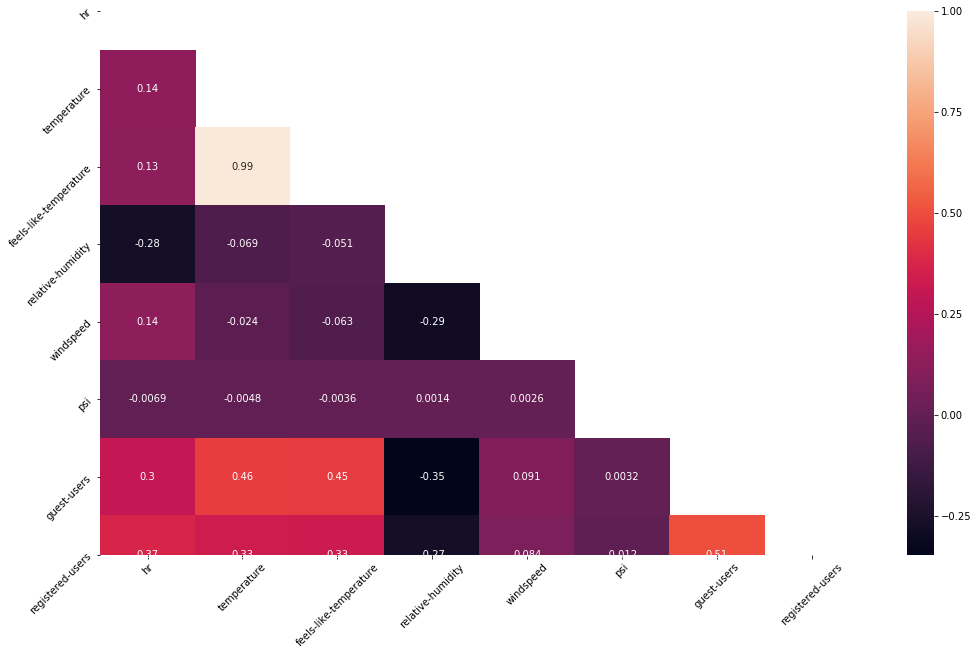

In [10]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(17,10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10 , rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10 , rotation=45)
plt.show()

Guest and registered users are correlated differently with the variables and with each other.
<br>This could be due to different demand needs (registered users could be using scooter for necessities - going to work/home, while guest users could be doing it for more leisure/recreational purposes.
<br>Forecast each user type diffently before aggregation.
<br>Humidity seems to have a negative effect while temperature has a positive effect

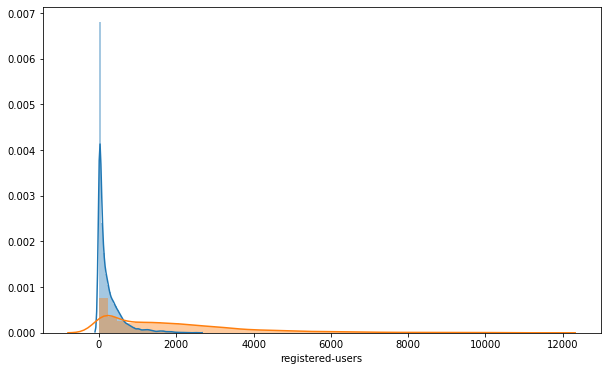

In [11]:
plt.figure(figsize=(10,6))
sns.distplot(df['guest-users'], label='guest-users')
sns.distplot(df['registered-users'], label='registered-users')

<b>Guest and registered users have different distribution but both have a long right tail -> to try lognormal for regression model

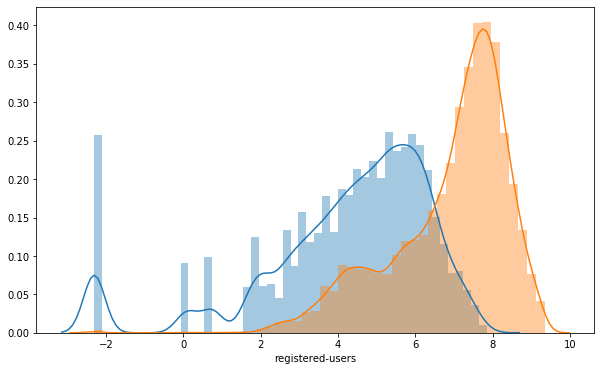

In [12]:
plt.figure(figsize=(10,6))
sns.distplot(df['guest-users'].apply(lambda x: np.log(x+0.1)).fillna(0), label='guest-users')
sns.distplot(df['registered-users'].apply(lambda x: np.log(x+0.1)).fillna(0), label='log_ruser')

## Date and time check

In [16]:
#convert to datetime
df['date'] = pd.to_datetime(df['date'])
df['date_time'] = pd.to_datetime(df.date) + df.hr.astype('timedelta64[h]')

## Datapoints

In [17]:
#check datapoints
df['date'].value_counts()
# 1 / 30 hours per day?

2011-10-01    30
2011-04-15    28
2012-07-30    28
2012-12-27    27
2011-06-04    27
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 731, dtype: int64

<b> More than 30 points in a day

In [18]:
df[df['date'] == pd.to_datetime('20111001', format='%Y%m%d', errors='ignore')].sort_values('hr')

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,date_time
6442,2011-10-01,0,clear,88.7,118.4,63.0,26.0,39,170,1382,2011-10-01 00:00:00
6443,2011-10-01,1,clear,87.0,116.6,67.0,22.0,36,79,614,2011-10-01 01:00:00
17938,2011-10-01,2,CLEAR,85.3,114.8,63.0,28.0,29,148,602,2011-10-01 02:00:00
6444,2011-10-01,2,CLEAR,85.3,114.8,63.0,28.0,29,148,602,2011-10-01 02:00:00
6445,2011-10-01,3,clear,85.3,114.8,59.0,28.0,12,58,220,2011-10-01 03:00:00
17603,2011-10-01,3,clear,85.3,114.8,59.0,28.0,12,58,220,2011-10-01 03:00:00
6446,2011-10-01,4,lear,83.6,113.0,58.0,28.0,30,12,80,2011-10-01 04:00:00
6447,2011-10-01,5,cloudy,83.6,113.0,62.0,20.0,38,6,48,2011-10-01 05:00:00
6448,2011-10-01,6,clear,81.9,111.2,67.0,22.0,43,26,190,2011-10-01 06:00:00
6449,2011-10-01,7,light snow/rain,81.9,111.2,67.0,17.0,32,43,394,2011-10-01 07:00:00


<b> Duplicates to be removed

In [39]:
#get rid of duplicates
df.drop_duplicates(inplace=True)
df['date'].value_counts()

2012-08-29    24
2012-12-20    24
2012-01-26    24
2011-10-17    24
2012-11-25    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 731, dtype: int64

In [40]:
#find missing values
df[df['date'] == pd.to_datetime('20110127', format='%Y%m%d', errors='ignore')].sort_values('hr')

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,date_time
587,2011-01-27,16,clear,65.0,87.8,55.0,13.0,16,7,295,2011-01-27 16:00:00
588,2011-01-27,17,clear,65.0,89.6,55.0,7.0,22,13,1070,2011-01-27 17:00:00
589,2011-01-27,18,clear,63.3,87.8,69.0,6.0,31,19,1316,2011-01-27 18:00:00
590,2011-01-27,19,clear,63.3,87.8,69.0,6.0,39,21,988,2011-01-27 19:00:00
591,2011-01-27,20,clear,61.6,86.0,74.0,6.0,13,30,718,2011-01-27 20:00:00
592,2011-01-27,21,clear,61.6,86.0,74.0,6.0,28,13,466,2011-01-27 21:00:00
593,2011-01-27,22,clear,61.6,86.0,74.0,6.0,20,2,346,2011-01-27 22:00:00
594,2011-01-27,23,clear,61.6,84.2,80.0,11.0,17,2,210,2011-01-27 23:00:00


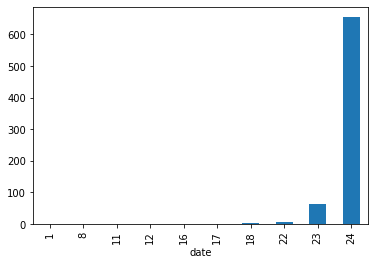

In [46]:
df['date'].value_counts().reset_index().groupby('date').size().plot.bar()

In [41]:
#check no. of days with missing values
print(df['date'].value_counts().reset_index().groupby('date').size())
print(df['date'].value_counts().reset_index().groupby('date').size()/df['date'].nunique())

date
1       1
8       1
11      1
12      1
16      1
17      1
18      2
22      6
23     62
24    655
dtype: int64
date
1     0.001368
8     0.001368
11    0.001368
12    0.001368
16    0.001368
17    0.001368
18    0.002736
22    0.008208
23    0.084815
24    0.896033
dtype: float64


<b> 723 (99%) of the days have >= 22hrs datapoints. impact of missing values should be limited. 
<br> drop the rest and interpolate the days with 22/23 hrs of values

In [38]:
#create dummy range of datetime
df['date'] = pd.to_datetime(df['date'])
df['date_time'] = pd.to_datetime(df.date) + df.hr.astype('timedelta64[h]')
date_rng = pd.date_range(start=df['date_time'].min(), end=df['date_time'].max(), freq='H')
df_full = pd.DataFrame(date_rng,columns=['date_time']).merge(df, how='left')
#convert to date and hr
df_full['date'] = df_full['date_time'].apply(lambda x: x.date())
df_full['hr'] = df_full['date_time'].apply(lambda x: x.hour)
print('before data drop #datapoints:', len(df_full))
#drop dates with less than 22 datapoints
date_count = df['date'].value_counts().reset_index()
dates_to_remove = date_count[date_count['date'] < 22]['index'].apply(lambda x: x.date()).tolist()
df_full = df_full[~df_full['date'].isin(dates_to_remove)]
#interpolate the remaining with previous hour values
df_full.ffill(axis = 0, inplace=True)
df_full.dropna(inplace=True)
print('after data drop #datapoints:', len(df_full))
#is null check
df_full.isnull().sum()

before data drop #datapoints: 18123
after data drop #datapoints: 17930


date_time                 0
date                      0
hr                        0
weather                   0
temperature               0
feels-like-temperature    0
relative-humidity         0
windspeed                 0
psi                       0
guest-users               0
registered-users          0
dtype: int64

## Time Trend

In [ ]:
#get day of the week and month to understand time feature relationship against traffic volume
df_full['day'] = df_full['date_time'].apply(lambda x: x.dayofweek)
df_full['month'] = df_full['date_time'].apply(lambda x: x.month)

### Month of the Year

In [ ]:
#check for user cycle in the day of the week
fig, axs = plt.subplots(2,figsize=(15,12))
sns.boxplot(x=df_full['month'], y=df_full['registered-users'],showmeans=True, ax = axs[0])
sns.boxplot(x=df_full['month'], y=df_full['guest-users'],showmeans=True, ax = axs[1])
plt.show()

<b> Both guest and registered users have lower usage towards the end/start of the year with greater effects on guest users

### Day of the Week

In [ ]:
#check for user cycle in the day of the week
fig, axs = plt.subplots(2,figsize=(15,12))
sns.boxplot(x=df_full['day'], y=df_full['registered-users'],showmeans=True, ax = axs[0])
sns.boxplot(x=df_full['day'], y=df_full['guest-users'],showmeans=True, ax = axs[1])
plt.show()

<b> As a necessity usage, registered users have lower weekends usage, while guest users (for leisure purposes) have higher weekends usage.

### Time of Day

In [ ]:
#check for user cycle in the time of the day
fig, axs = plt.subplots(2,figsize=(15,12))
sns.boxplot(x=df_full['hr'], y=df_full['registered-users'],showmeans=True, ax = axs[0])
sns.boxplot(x=df_full['hr'], y=df_full['guest-users'],showmeans=True, ax = axs[1])
plt.show()

<b> Registered/guest users have different trends throughout the day. 
<br> Registered users are more active in morning/evening, postulated to be going/coming back from work/school
<br> Guest users are more active in the afternoon. could be tourist or other leisure users
<br> Outliers to be rectified using log target variables in model

### Interaction effects (Time and Day)

Active users throughout daytime between weekdays and weekends should be different. To explore the interaction effects.

In [ ]:
#interaction effects - time of day and day of week
#check for traffic cycle in the day of the week
for user in ['registered-users','guest-users']:
    print(user)
    fig, ax = plt.subplots(figsize=(20,10))
    sns.pointplot(x=df_full['hr'], y=df_full[user],showmeans=True,hue=df_full['day'])
    plt.show()

<b> There are interaction effect. For registered users, weekends have more gradual increase and decline, while weekdays have more spikes usage in the morning and evenings. <br> For guest-users, weekends afternoons are more active periods relative to weekdays. Get the interaction term of weekday/end on time.

### Daily time trend

In [ ]:
#agg daily user demand
df_date = df_full.groupby('date')['registered-users','guest-users'].sum().reset_index()

In [ ]:
#use log users to better observe datapoints, and for a lognormal distribution
df_full['lg_reg_user'] = df_full['registered-users'].apply(lambda x: np.log(x+0.1))
df_full['lg_gs_user'] = df_full['guest-users'].apply(lambda x: np.log(x+0.1))
df_date['lg_reg_user'] = df_date['registered-users'].apply(lambda x: np.log(x))
df_date['lg_gs_user'] = df_date['registered-users'].apply(lambda x: np.log(x))
df_date['lg_reg_user'].describe()

In [ ]:
#take first diff and test on stationarity
# Define a Dickey-Fuller test. Stationarity present if p-value<0.05
def test_stationarity(timeseries, window=7):
    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=window, center=False).mean()
    rolstd = timeseries.rolling(window=window, center=False).std()
    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Performing a Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


#daily trend
for user in ['lg_reg_user','lg_gs_user']:#['guest-users','registered-users']:
    print(user)
    test_stationarity(df_date[user], window=7)

<b> There is underlying trend (non-stationarity) present for daily user demand.

In [ ]:
# First difference:
for user in ['lg_reg_user','lg_gs_user']:#['guest-users','registered-users']:
    print(user)
    df_date['first_difference'] = df_date[user] - df_date[user].shift(1)  
    test_stationarity(df_date.first_difference.dropna(inplace=False), window=7)

<b>We observe time trend (non-stationarity) in daily datapoints which can be removed from first differences.

### Hourly time trend

In [ ]:
#hourly trend
for user in ['lg_reg_user','lg_gs_user']:#['guest-users','registered-users']:
    print(user)
    test_stationarity(df_full[user], window=24)

<b> Even though p-value of dickey-fuller test for hourly trend is < 0.01, we can clearly observe from the graphs above that underlying daily trend is present in the dataset. <br>
Detrend hourly dataset by taking daily (24hr) difference. Better stationarity as observed in the graphs below.

In [ ]:
# First difference:
for user in ['lg_reg_user','lg_gs_user']:#['guest-users','registered-users']:
    print(user)
    df_full['first_difference'] = df_full[user] - df_full[user].shift(24)  
    test_stationarity(df_full.first_difference.dropna(inplace=False))

## Humidity

In [ ]:
sns.lmplot(x="relative-humidity", y="guest-users",data=df_full)
sns.lmplot(x="relative-humidity", y="registered-users",data=df_full)

<b> We observe a negative relationship between humidity and users, however the datapoints may be clumped together. We have to stratify by the different parts of the day to identify whether humidity-users relationship strengthen/weaken throughout the day.</b> <br> - For example post-midnight, a high humidity level will not affect no. of users since most people are asleep.

### Humidity and time of the day interaction effects

In [ ]:
#break day into different parts
df_full['daypart'] = df_full.hr.apply(lambda x: 'morn' if (x >=6 and x<=10) else 
                                       'aftern' if (x >=11 and x<= 15) else 
                                       'eve' if (x >=16 and x<= 20) else 
                                       'night' if (x >=21 or x == 0) else
                                       'postmid' if (x >=1 and x <=5) else
                                       0)

In [ ]:
sns.lmplot(x="relative-humidity", y="guest-users", hue="daypart",data=df_full)
sns.lmplot(x="relative-humidity", y="registered-users", hue="daypart",data=df_full)

<b> We can observe guest users demand are more sensitive to humidity, while humidity-demand relationship weakens at night/post mid-night. <br>
We also observe that registered users are less sensitive to humidity in the morning -> getting to work/school is probably more important, while humidity-demand relationship also weakens at night/post mid-night.

## Temperature

In [ ]:
df_full.head()

In [ ]:
df_full['temperature'].hist()

<b> Even though some temperature is above 104°F (40°C), the distribution is normal and does not seem to be outliers. Not to drop off these datapoints.

### Temp and feels-like-temp difference investigation

feels-like temperature could be affected by humidity and the wind factor.

In [ ]:
#check the reason before temp feeling different
df_full['temp_feel_diff'] = df_full['feels-like-temperature']-df_full['temperature']

In [ ]:
df_full['temp_feel_diff_cat'] = df_full['temp_feel_diff'].apply(lambda x: 'high_diff' if (x > 40 or x < -20) else 'low_diff')

In [ ]:
sns.pairplot(df_full[['temperature','feels-like-temperature','relative-humidity','windspeed','temp_feel_diff','temp_feel_diff_cat']], 
             hue='temp_feel_diff_cat')

<b> The largest temperature/feels-like-temperature differences mostly occur at the higher temperature range.
<br> However there is no observable relationship between these differences and other weather elements - humidity and windspeed.

### Temp and time of the day

In [ ]:
sns.lmplot(x="temperature", y="guest-users", hue="daypart",data=df_full)
sns.lmplot(x="temperature", y="registered-users", hue="daypart",data=df_full)

<b> Similar to humidity, guest and registered users do have different sensitivity to temperature at different parts of the day.
<br> Both users are less sensitive post midnight, while highest sensitivity occurs in the evening.
<br> An interesting observation would be higher temperature and higher no. of users. Lower demand from lower temperature could be due to other correlated factors such as the travelling season in singapore (colder period of Nov/Dec/Jan) and rainy days.

### Higher temp higher demand?

In [ ]:
fig, axs = plt.subplots(2,figsize=(15,12))
sns.boxplot(x=df_full['weather'], y=df_full['temperature'],showmeans=True, ax = axs[0])
sns.boxplot(x=df_full['month'], y=df_full['temperature'],showmeans=True, ax = axs[1])
plt.show()
#the hypothesis of lower temperature from rainy days and holiday seasons seems to be true

In [ ]:
#feels-like-temperature has same relationship with user demand.
sns.lmplot(x="feels-like-temperature", y="guest-users", hue="daypart",data=df_full)
sns.lmplot(x="feels-like-temperature", y="registered-users", hue="daypart",data=df_full)

## PSI

In [ ]:
sns.lmplot(x="psi", y="guest-users",data=df_full)
sns.lmplot(x="psi", y="registered-users",data=df_full)

In [ ]:
df_full.psi.max()

<b> As max psi is at 49, well within safety levels (moderate at 50), the impact on user demand as observed, is negligible.

## Windspeed

In [ ]:
sns.lmplot(x="windspeed", y="guest-users",data=df_full)
sns.lmplot(x="windspeed", y="registered-users",data=df_full)

<b> No strong observable relationship between windspeed strength and user demand.

In [ ]:
#remove non-windy days no observable relationship
df_full['wind'] = df_full['windspeed'].apply(lambda x: 1 if x>0 else 0)
sns.lmplot(x="windspeed", y="guest-users",data=df_full[df_full['wind']==1], hue="daypart")
sns.lmplot(x="windspeed", y="registered-users",data=df_full[df_full['wind']==1], hue="daypart")

In [ ]:
#No wind days have lower user demand than days with wind.
sns.catplot(x='wind', y='guest-users', 
               data=df_full, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right');
sns.catplot(x='wind', y='registered-users', 
               data=df_full, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right');

<b> No wind days have lower user demand than days with wind.

## Weather

In [ ]:
df_full.weather.value_counts()
#club upper and lower case, mispelling together

In [ ]:
df_full['weather'] = df_full.weather.apply(lambda x: x.upper())
df_full['weather'] = df_full.weather.apply(lambda x: 'CLOUDY' if x in 'CLOUDY' else
                                            'CLEAR' if x in 'CLEAR' else
                                            'RAIN' if x in 'LIGHT SNOW/RAIN' else
                                            'RAIN' if x in 'HEAVY SNOW/RAIN' else
                                            x)
df_full.weather.value_counts()

In [ ]:
for user in ['registered-users','guest-users']:
    fig, ax = plt.subplots(figsize=(20,10))
    sns.pointplot(x=df_full['daypart'], y=df_full[user],showmeans=True,hue=df_full['weather'])
    plt.show()

<b> We do observe more users (registered & guest) in the order of clear > cloudy > rainy weather, throughout different times of the day.

## User Demand

### User Demand Autocorrelation

In [ ]:
for user in ['lg_reg_user','lg_gs_user']:#['guest-users','registered-users']:
    print(user)
    plot_acf(df_full[user], lags =48)
    plt.show()

<b> Both registered and guest user shows strong autocorrelation on lagged demand, due to daily trend cycles. We can use a lag of user demand to predict future demand.

### User Demand and Standard Deviations

In [ ]:
gs_grp = df_full.groupby(['day','hr'])['lg_gs_user'].agg(['mean','std','min','max']).reset_index()
gs_grp_merge = df_full.merge(gs_grp, on=['day','hr'])
print('Log guest-users hourly mean-standard deviation across daypart')
sns.lmplot(x="std", y="mean", hue="daypart",data=gs_grp_merge);

<b> For guest users we obvserve that hours with higher mean have smaller deviations in demand, mostly in the afternoon and evening. Night and morning sees more fluctuation whiel post-midnight has the highest fluctuations given a smaller mean.

In [ ]:
reg_grp = df_full.groupby(['day','hr'])['lg_reg_user'].agg(['mean','std','min','max']).reset_index()
reg_grp_merge = df_full.merge(reg_grp, on=['day','hr'])
print('Log registered-users hourly mean-standard deviation across daypart')
sns.lmplot(x="std", y="mean", hue="daypart",data=reg_grp_merge);

<b> For registered users we observe for most period of the day which high user demand, there is little deviations as well. The highest fluctuation in demand tend to be post midnight, which has lower user demand on average as well.